In [1]:
import os
import logging
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from metpy.interpolate import interpolate_to_grid

from library.commons import check_parameters
from library.datahub import gen_etopo, get_station_data, open_topo

# config logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Setup

In [2]:
# set your domain, lon_min, lon_max, lat_min, lat_max
DOMAIN = [-80, -25, -60, 15]

# set your horizontal resolution in degrees
RES = 0.25

# set variables list
variables = ['tmax', 'tmin']

# set your start and end date
START_DATE = datetime(2024, 1, 1)
END_DATE = datetime(2024, 1, 1)

# set interpolation kwargs
interpol_kwargs = {
    "interp_type": "cressman",
    "minimum_neighbors": 2,
    "search_radius": 10,  # the circles radius will be search_radius*hres in degrees
    "hres": RES
}

# if true the lapse rate will be applied to make interpolate all station in the same altitude level
TEMPERATURE_VARS = True

# dry adiabatic lapse rate (9.8 °C/km)
LAPSE_RATE = 9.8 

# if true, save intermediate files, seeking to reduce the use of external APIs (meteostat and open topo data)
SAVE_STATIC_FILES = True

# set engine to handle with netcdf files
nc_engine = 'netcdf4'  # options 'netcdf4' and 'xarray'

# Checkings

Let's check the consistence of our settings before starting the process

In [3]:
NC_ENGINE = nc_engine.lower()  # avoid upper case errors
VARIABLES = [variables] if not isinstance(variables, list) else variables  # check right type

# this function will raise an error if the params are not consistents
check_parameters(NC_ENGINE, DOMAIN, RES, START_DATE, END_DATE, VARIABLES)

True

# Pre-processing

In [4]:
# set interpolated grid parameters
grid_lat = np.arange(DOMAIN[-2], DOMAIN[-1] + RES, RES)
grid_lon = np.arange(DOMAIN[0], DOMAIN[1] + RES, RES)

dates = pd.date_range(start=START_DATE, end=END_DATE, freq='1D').to_pydatetime()

boundary_coords = {
        'west': grid_lon.min(),
        'south': grid_lat.min(),
        'east': grid_lon.max(),
        'north': grid_lat.max()
    }

interpol_kwargs.update(dict(boundary_coords=boundary_coords))
interpol_kwargs

{'interp_type': 'cressman',
 'minimum_neighbors': 2,
 'search_radius': 10,
 'hres': 0.25,
 'boundary_coords': {'west': -80.0,
  'south': -60.0,
  'east': -25.0,
  'north': 15.0}}

# Getting stations file

For educational purposes, we'll use Meteostat to retrieve data from weather stations; any other CSV file can be used as long as it follows the same format.

It must be the following columns: station (which informs the id or name string), latitude, longitude and elevation, the column(s) with VARIABLES defined in setup is(are) necessary as well

In [5]:
# set specified domain to get weather station data, format (domain_top, domain_left), (domain_bottom, domain_right)
ws_outpath = f"static/stations_{DOMAIN[0]}_{DOMAIN[1]}_{DOMAIN[2]}_{DOMAIN[3]}_{START_DATE:%Y%m%d}_{END_DATE:%Y%m%d}.csv"

if os.path.exists(ws_outpath):
    logging.info(f"opening weather station file @ {ws_outpath}")
    daily_data = pd.read_csv(ws_outpath)
    
else:

    # get weather station data using meteostat
    daily_data = get_station_data(DOMAIN, START_DATE, END_DATE)
    
    if SAVE_STATIC_FILES:
        logging.info(f"creating csv with data station @ {ws_outpath}")
        daily_data.to_csv(ws_outpath)
    
# dropna and select columns
to_select_colunms = ['time', 'station', 'latitude', 'longitude', 'elevation'] + VARIABLES

try:
    daily_data = daily_data.dropna(subset=VARIABLES).reset_index()
    daily_data = daily_data.loc[:, to_select_colunms]

except KeyError as e:
    raise KeyError(f"there are variables not found in dataframe columns @ {e}")

daily_data['time'] = pd.to_datetime(daily_data['time'])

daily_data.head()

2024-09-30 10:50:24,784 - INFO - getting weather station into domain
2024-09-30 10:50:46,561 - INFO - creating csv with data station @ static/stations_-80_-25_-60_15_20240101_20240101.csv


,time,station,latitude,longitude,elevation,tmax,tmin
0,2024-01-01,69377,4.0700,-73.5500,378.0,31.2,21.0
1,2024-01-01,78792,9.0500,-79.3667,45.0,32.0,24.0
2,2024-01-01,78808,8.9833,-79.5500,66.0,33.0,25.0
3,2024-01-01,78922,14.7667,-60.8833,33.0,28.1,23.7
4,2024-01-01,78925,14.6000,-61.0000,5.0,30.0,22.0


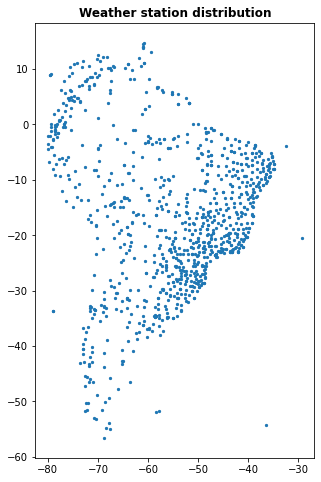

In [6]:
# a simple plot just to check the weather stations distribution
fig, ax = plt.subplots(figsize=(5, 8))
ax.scatter(daily_data['longitude'].values, daily_data['latitude'].values, s=5)
ax.set_title(f"Weather station distribution", weight='bold')
plt.show()
plt.close()

# Opening topography file

You can use another topography file, the final topo array must be in meters unit

In [7]:
topo_pathfile = f'static/ETOPO_lon_{DOMAIN[0]}_{DOMAIN[1]}_lat_{DOMAIN[2]}_{DOMAIN[3]}_r{RES}.nc'
should_open_topo = True

# you can use a specific topography file
# to ensure the right progress of the code, the netcdf file must be the following pattern
# dimensions: y (with latitude values in degrees) ; x (with longitude values in degrees)
# variable: z (y, x) - 2D array with elevation values in meters

# topo_pathfile = 'static/<your_netcdf_topography_file>.nc'  


# create etopo file from opentopodata api, it may take some time according to domain and horizontal resolution 
if not os.path.exists(topo_pathfile):
    if SAVE_STATIC_FILES:
        logging.info(f'Creating topo file for specific domain and resolution @ {DOMAIN} - {RES}')
        gen_etopo(grid_lat, grid_lon, topo_pathfile=topo_pathfile)
        
    else:
        topo = gen_etopo(grid_lat, grid_lon, topo_pathfile=topo_pathfile, save_output=False)
        should_open_topo = False
        


2024-09-30 10:50:53,525 - INFO - Creating topo file for specific domain and resolution @ [-80, -25, -60, 15] - 0.25
Processing Coordinates: 100%|████████████████████████████████████████████████████| 994/994 [10:46<00:00,  1.54it/s]
2024-09-30 11:01:40,309 - INFO - nan values were found filling them @ fraction of nans 0.06358894183791584
2024-09-30 11:01:45,447 - INFO - file static/ETOPO_lon_-80_-25_lat_-60_15_r0.25.nc created


2024-09-30 11:01:52,423 - INFO - 
Checking boundaries:
    expected domain: [-80, -25, -60, 15]
    lats: (-60.0, 15.0)
    lons: (-80.0, -25.0)
        


CPU times: user 95.7 ms, sys: 1.14 ms, total: 96.9 ms
Wall time: 93 ms


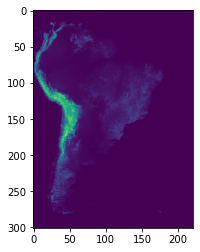

In [8]:
%%time
if should_open_topo:
    topo, lats_, lons_ = open_topo(topo_pathfile, grid_lat, grid_lon, nc_engine=NC_ENGINE)
    
    logging.info(
        f"""
Checking boundaries:
    expected domain: {DOMAIN}
    lats: {lats_[0], lats_[-1]}
    lons: {lons_[0], lons_[-1]}
        """
         )

topo[topo < 0] = 0  # avoid negative altitudes
plt.imshow(topo[::-1])

# Uniform elevations functions

Let's define functions to include topography in temperature variables, using the lapse rate value defined in setup

In [9]:
@np.vectorize
def alt2ground(arr, topo):
    '''
    going down with station data from elevation to sea level
    
    :param arr: np.array (1D)  - weather station temperature values
    :param topo: np.array (1D) - weather station elevation (in meters)
    '''
    return arr + LAPSE_RATE * (topo/1000)

@np.vectorize
def ground2alt(arr, topo):
    '''
    going up with interpolation result to surface elevation
    
    :param arr: np.array (2D)  - interpolated temperature values
    :param topo: np.array (2D) - topography grid array (in meters)
    '''
    return arr - LAPSE_RATE * (topo/1000)

# Applying interpol

In [ ]:
interpolated_ds = {}
times = daily_data['time'].unique()
for variable in VARIABLES:
    interpolated_ds[variable] = []
    
    for date in times:
        
        logging.info(f"Starting {variable} interpolation @ {date:%Y%m%d}")
        
        df_date = daily_data.loc[daily_data['time'] == date]
        
        values_ws = df_date[variable].values
        lats_ws = df_date['latitude'].values
        lons_ws = df_date['longitude'].values
        elevation_ws = df_date['elevation'].values

        if TEMPERATURE_VARS:
            values_ws = alt2ground(values_ws, elevation_ws)

        grid_x, grid_y, grid = interpolate_to_grid(lons_ws,
                                                   lats_ws,
                                                   values_ws,
                                                   **interpol_kwargs)


        if TEMPERATURE_VARS:
            grid = ground2alt(grid, topo)

        interpolated_ds[variable].append(grid) 

        logging.info(f"Interpolation of {variable} on {date:%Y%m%d} done")

2024-09-30 11:01:58,752 - INFO - Starting tmax interpolation @ 20240101


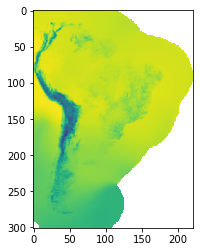

In [12]:
plt.imshow(interpolated_ds[variable][0][::-1])